In [17]:
# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the original graph2nn github repo.

# File modifications and additions by Rowan AI Lab, licensed under the Creative Commons Zero v1.0 Universal
# LICENSE file in the root directory of this source tree.

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import multiprocessing as mp
import pathos
from pathos.multiprocessing import ProcessingPool as Pool
import os
from networkx.utils import py_random_state
from scipy.io import savemat
import time

sns.set_context("poster")
sns.set_style("ticks")
current_palette = sns.color_palette('muted',n_colors=9)
np.set_printoptions(linewidth=200)

def compute_count(channel, group):
    # divide = number of edges / number of nodes
    divide = channel//group
    remain = channel%group

    out = np.zeros(group, dtype=int)
    out[:remain]=divide+1
    out[remain:]=divide
    return out


# Decorator to generate a random.Random instance (or equiv)
@py_random_state(3)
## n=node, k=degree, p=rewiring probability
def ws_graph(n, k, p, seed=1):
    """Returns a ws-flex graph, k can be real number in [2,n]
    """
    assert k>=2 and k<=n
    # compute number of edges:
    # edge = floor(n x k /2)
    edge_num = int(round(k*n/2))
    count = compute_count(edge_num, n)
#     print("count :", count)
#     Create an empty graph with no nodes and no edges
    G = nx.Graph()
    for i in range(n):
        source = [i]*count[i]
        target = range(i+1,i+count[i]+1)
        target = [node%n for node in target]
        G.add_edges_from(zip(source, target))
    # rewire edges from each node
    nodes = list(G.nodes())
    for i in range(n):
        u = i
        target = range(i+1,i+count[i]+1)
        target = [node%n for node in target]
        for v in target:
            if seed.random() < p:
                w = seed.choice(nodes)
                # Enforce no self-loops or multiple edges
                while w == u or G.has_edge(u, w):
                    w = seed.choice(nodes)
                    if G.degree(u) >= n - 1:
                        break  # skip this rewiring
                else:
                    G.remove_edge(u, v)
                    G.add_edge(u, w)
    return G



@py_random_state(4)
def connected_ws_graph(n, k, p, tries=100, seed=1):
    """Returns a connected ws-flex graph.
    """
    for i in range(tries):
        # seed is an RNG (random number generator) so should change sequence on each call
        G = ws_graph(n, k, p, seed)
##  nx.is_connected checks whether every node in a graph G is reachable from every other node in G.
##  This is equivalent to saying that there is one connected component in G (i.e. len(nx.connected_components(G)) == 1).
        if nx.is_connected(G):
            return G
    raise nx.NetworkXError('Maximum number of tries exceeded')


def compute_stats(G):
    # Compute the clustering coefficient for nodes of G through nx.clustering(G)
    # sort the clustering coefficients of graph G
    G_cluster = sorted(list(nx.clustering(G).values()))
    # Avg the Clustering Coefficients (C)
    cluster = sum(G_cluster) / len(G_cluster)
    # Find avg path length (L)
    path = nx.average_shortest_path_length(G)
    return cluster, path

def norm(x):
    ## to 0-1
    x = x-x.min()
    if x.max()==0:
        x[:]=0
    else:
        x = x/x.max()
    return x



def get_graph(n,degree,p,repeat=30):
    # row: repeat, column: n,degree,p,seed,cluster,path
    # generate 30 random graphs with seed i
    # n=node, k=degree, p=rewiring probability
    
    # result is a 30 x 6 matrix
    result = np.zeros((repeat, 6))
    A_list=[]
    for i in range(repeat):
        graph = connected_ws_graph(n=n, k=degree, p=p, seed=i)
#         calc adjacency matrices from graphs and append them in a list
#         adjacency_matrix(G,nodelist=sorted(G.nodes()))
        A = nx.to_numpy_matrix(graph, nodelist=sorted(graph.nodes())) 
        A_list.append(A)
        cluster, path = compute_stats(graph)
        result[i] = [n, degree, p, i, cluster, path]
        
    Adj_Stack = np.empty((len(A_list),), dtype=np.object)
    for i in range(len(A_list)):
        Adj_Stack[i] = A_list[i]
    results = np.column_stack((result, Adj_Stack))
    return results

### 4: 30, 20, 30
### 16: 30, 200, 300
### 64: 30, 300, 300
def sweep_graphs(n, processes=4):
    print(n)
    t0 = time.time()
    pool = mp.Pool(processes=processes)
    deg_min = 4
    deg_max = n-2
    degree_range = np.square(np.linspace(np.sqrt(deg_min),np.sqrt(deg_max),300)) # np.linspace(8, 62, 300)
    p_range = np.linspace(0,1,300)**2 
    args_all = [(n,degree,p) for degree in degree_range for p in p_range]
    results = [pool.apply_async(get_graph, args=args) for args in args_all]
    output = [p.get() for p in results]
    output = np.concatenate(output,axis=0)  
    
#     for results, A_Lists in [pool.apply_async(get_graph, args=args) for args in args_all]:
#         results.append(results)
#         A_Lists.append(A_Lists)
#     A_lists = []
#     for e in output:
#         A_lists.append(e[1:])
#         print("Length :", len(A_lists))
#         print(A_lists)

#     mat_dir = 'matlab_directory'
#     if not os.path.isdir(mat_dir):
#         os.mkdir(mat_dir)
#     savemat("{}/30Sep_Graph_measures_plus_adjacency_matrices_{}n.mat".format(mat_dir,n), {"output":output})
    
    dir_out = 'graph_configs'
    if not os.path.isdir(dir_out):
        os.mkdir(dir_out)
    np.save('{}/all_{}n_7elements.npy'.format(dir_out,n),output)
    
    t1 = time.time()
    print('time: {}'.format(t1-t0))

In [18]:
# Note: by default this will take ~1.5hr for 100-core cpu. 
# You can adjust the range of graph sweeping for faster performance

### Sweep WS-flex graph, 16 nodes
# sweep_graphs(16, processes=4)
### Sweep WS-flex graph, 64 nodes
# sweep_graphs(64, processes=8)
# sweep_graphs(4, processes=4)

time: 10793.821956634521


In [1]:
# results, Adjacencies = get_graph(4,4,0.5,repeat=30)
# print("Results Length :", results[0,:], "Adjacencies Length :", Adjacencies[0])
# print("Results type :", type(results), "Adjacencies type :", type(Adjacencies))
# print("Results Length :", results.shape, "Adjacencies Length :", Adjacencies.shape)

In [39]:
combined = np.column_stack((results, Adjacencies))
print("First Row :", combined[0:2,:])

First Row : [[4.0 4.0 0.5 0.0 1.0 1.0 matrix([[0., 1., 1., 1.],
        [1., 0., 1., 1.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.]])]
 [4.0 4.0 0.5 1.0 1.0 1.0 matrix([[0., 1., 1., 1.],
        [1., 0., 1., 1.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.]])]]


In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import multiprocessing as mp
import pathos
from pathos.multiprocessing import ProcessingPool as Pool
import os
from networkx.utils import py_random_state
from scipy.io import savemat
import time

sns.set_context("poster")
sns.set_style("ticks")
current_palette = sns.color_palette('muted',n_colors=9)
np.set_printoptions(linewidth=200)

In [5]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
# call load_data with allow_pickle implicitly set to true
result = np.load('graph_configs/all_64n_7elements.npy')
# restore np.load for future normal usage
np.load = np_load_old

In [ ]:
### Subsample WS-flex graphs

# compute sparsity
result[:,1] = result[:,1]/result[:,0]  # k/n ... degree/nodes
# filter too sparse graphs
result = result[result[:,1]>=0.125,:]
# shuffle
np.random.seed(1)
id_random = np.random.permutation(result.shape[0])
result_shuffle = result[id_random,:]

print("result_shuffle shape :", result_shuffle.shape)
print(result_shuffle[0])
print(len(result_shuffle))
print('sparsity', result[:,1].min(), result[:,1].max())
print('clustering', result[:,-3].min(), result[:,-3].max())
print('path', result[:,-2].min(), result[:,-2].max())


bins_clustering = np.linspace(0,1,15*9+1)
bins_path = np.linspace(1,4.5,15*9+1)
print("bins_clustering length:", len(bins_clustering))
print("bins_path length:", len(bins_path))

digits_clustering = np.digitize(result_shuffle[:,-3],bins_clustering)
digits_path = np.digitize(result_shuffle[:,-2],bins_path)
print("bins_clustering shape:", bins_clustering.shape)
print("bins_path shape:", bins_path.shape)

thresh = 1
filter_1 = []
filter_2 = []
filter_3 = []
counts = np.zeros((len(bins_clustering)+1, len(bins_path)+1))
ids = np.ones((len(bins_clustering)+1, len(bins_path)+1),dtype=int)*-1
print("counts shape:", counts.shape)
print("ids:", ids.shape)

for i in range(len(result_shuffle)):
    if counts[digits_clustering[i], digits_path[i]]<thresh:
        ids[digits_clustering[i], digits_path[i]] = i
        counts[digits_clustering[i], digits_path[i]] += 1
        filter_3.append(i)
        if digits_clustering[i]%9==5 and digits_path[i]%9==5:  
            filter_1.append(i)
        if digits_clustering[i]%9 in [2,5,8] and digits_path[i]%9 in [2,5,8]:
            filter_2.append(i)

for i in range(len(bins_clustering)+1):
    for j in range(len(bins_path)+1):
        if i%9==5 and j%9==5 and counts[i, j] == 0 and bins_clustering[i]>0.75:
            flag = False
            for m in range(i-1,i+2):
                if flag:
                    break
                for k in range(j-3,j+4):
                    if counts[m,k] != 0:
                        filter_1.append(ids[m,k])
                        filter_2.append(ids[m,k])
                        flag = True
                        break
            continue
        elif i%9 in [2,5,8] and j%9 in [2,5,8] and (not (i%9==5 and j%9==5)) and counts[i, j] == 0 and bins_clustering[i]>0.75:
            flag = False
            for m in range(i,i+1):
                if flag:
                    break
                for k in range(j-1,j+2):
                    if counts[m,k] != 0:
                        filter_2.append(ids[m,k])
                        flag = True
                        break
            
print(len(filter_1))
print(len(filter_2))
print(len(filter_3))
print(len(result_shuffle))

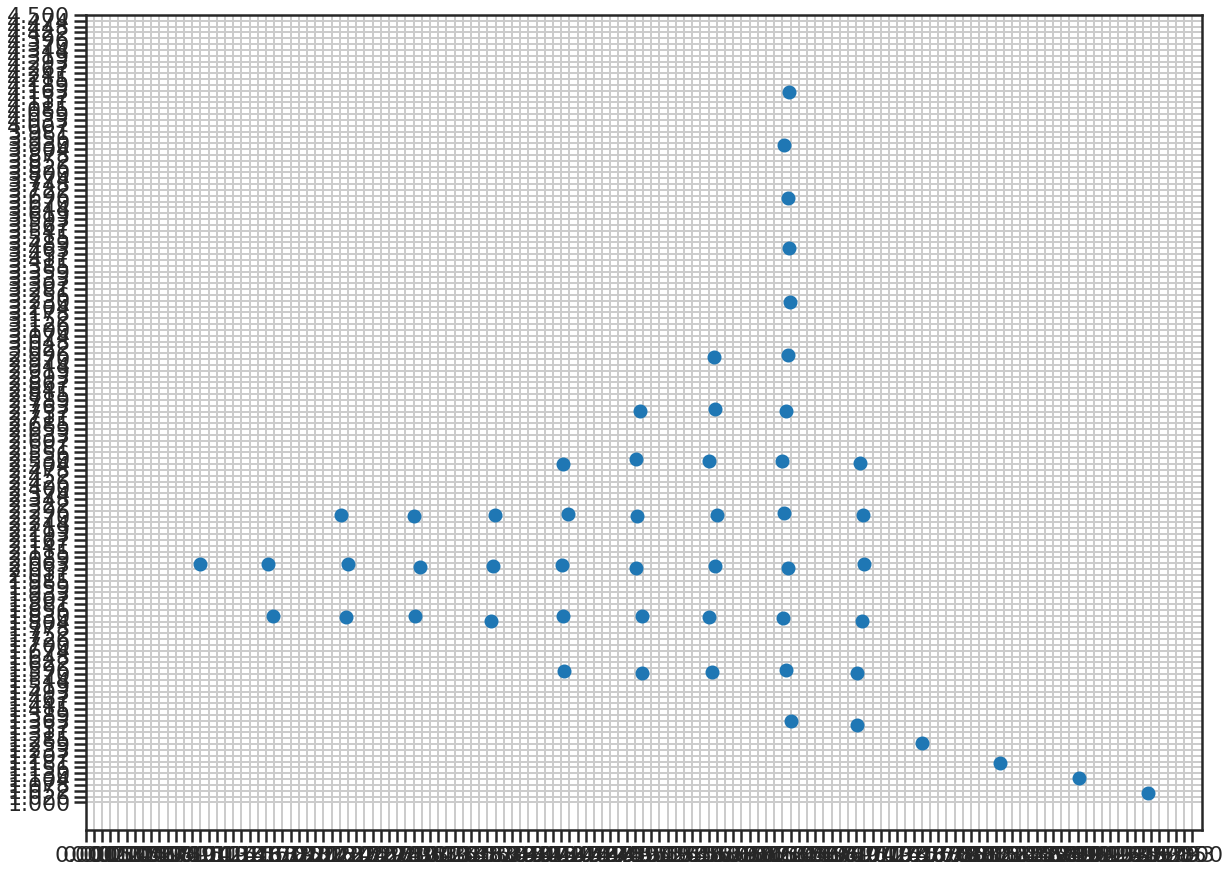

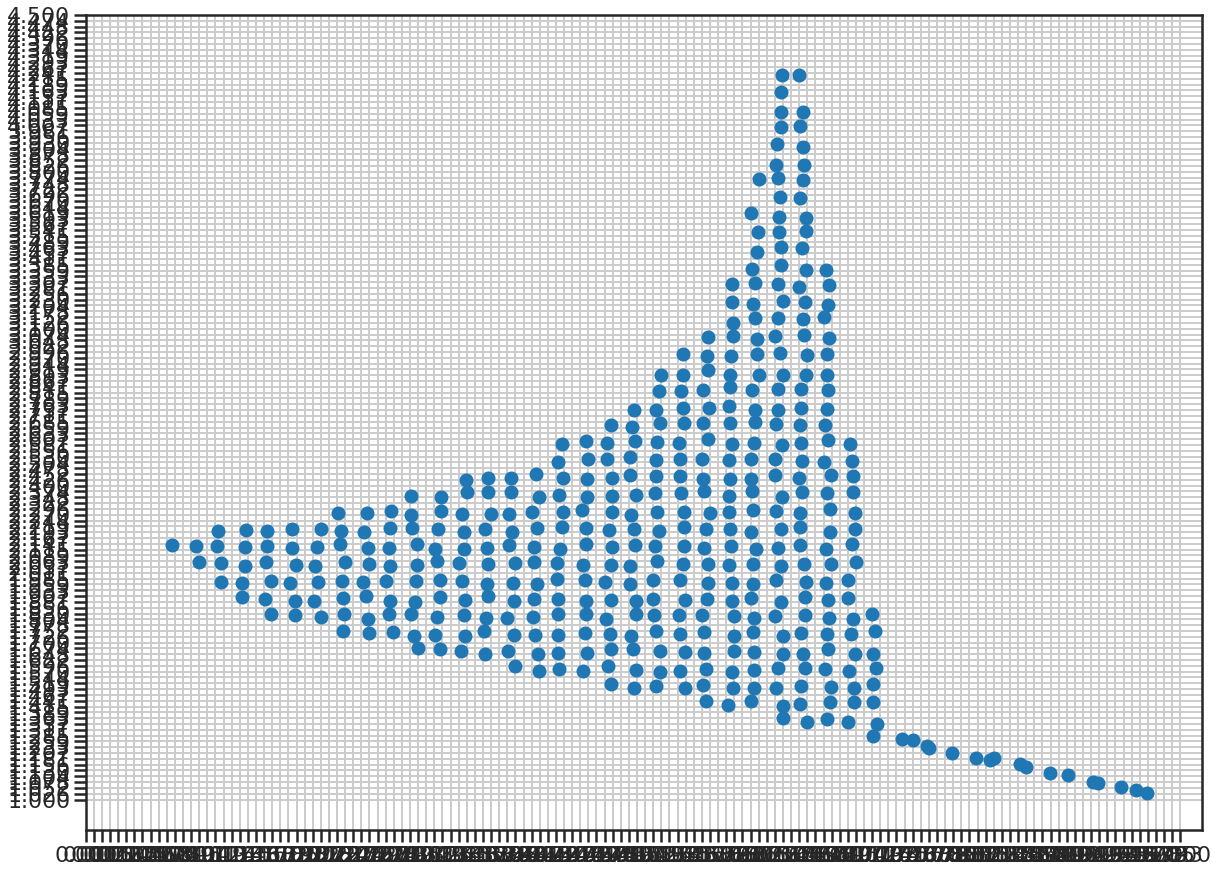

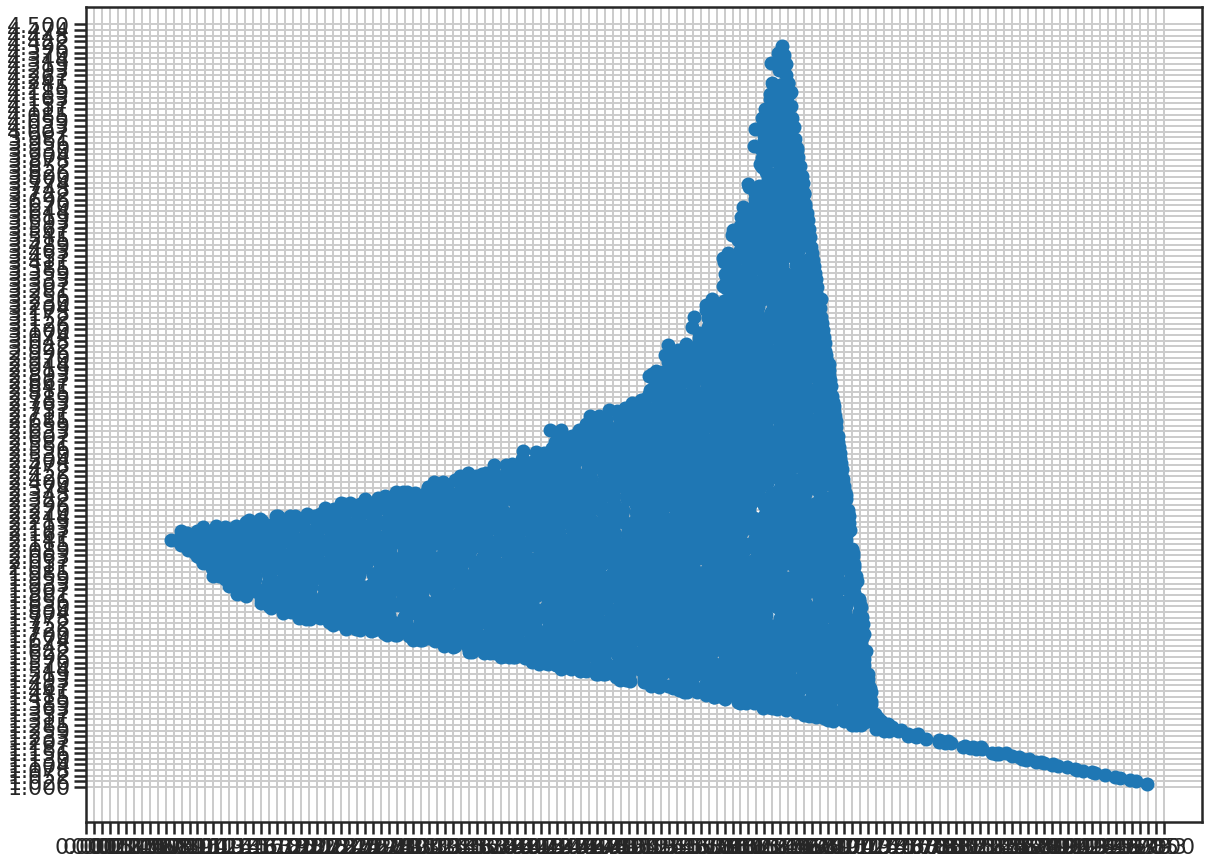

In [8]:
result_plot_1 = result_shuffle[filter_1]
result_plot_2 = result_shuffle[filter_2]
result_plot_3 = result_shuffle[filter_3]

for i in filter_1:
    assert i in filter_2
    assert i in filter_3
    
for i in filter_2:
    assert i in filter_3

plt.figure(figsize=(20,15))
plt.scatter(result_plot_1[:,-3],result_plot_1[:,-2])
plt.xticks(bins_clustering)
plt.yticks(bins_path)
plt.grid(True)

plt.figure(figsize=(20,15))
plt.scatter(result_plot_2[:,-3],result_plot_2[:,-2])
plt.xticks(bins_clustering)
plt.yticks(bins_path)
plt.grid(True)

plt.figure(figsize=(20,15))
plt.scatter(result_plot_3[:,-3],result_plot_3[:,-2])
plt.xticks(bins_clustering)
plt.yticks(bins_path)
plt.grid(True)

In [11]:
# # save
np.save('graphs_n64_54.npy',result_plot_1)
np.save('graphs_n64_441.npy',result_plot_2)
np.save('graphs_n64_3854.npy',result_plot_3)

In [ ]:
mat_dir = 'matlab_directory'
savemat("{}/Graphs_plus_adjacencices_64n_54.mat".format(mat_dir), {"result_plot_1":result_plot_1})